#Part 1
### Exercise 1: Creation of a phantom

Time of creation of phantom: 0.01 seconds


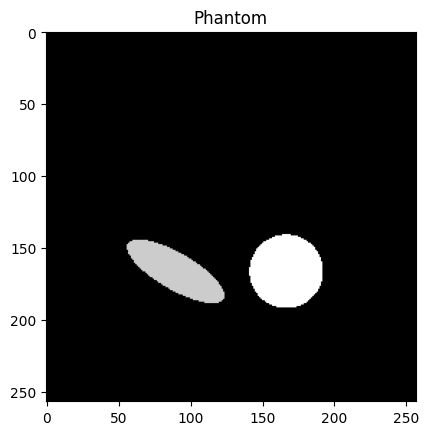

In [1]:
import numpy as np
from scipy.fftpack import fft, ifft, fftshift
import matplotlib.pyplot as plt
import time

RAMLAK = 0
SHEPPLOGAN = 1
COSINE = 2

# (a) Write a script called “COMPUTERTOMOGRAPHY.m”. Here all important variables are to be declared and the required functions are to be called.
# In Python, this is done by defining the main script and importing necessary libraries.

# (b) Write a function “InitObjects.m” to initialize the parameters of the different objects (circles and ellipses*)
def init_objects():
    # Initialize circle parameters
    # Each row: [radius, center_x, center_y, gray_value]
    circle_objects = np.array([
        [0.2, 0.3, 0.3, 1.0]
    ])

    # Initialize ellipse parameters (optional)
    # Each row: [semi-major, semi-minor, center_x, center_y, angle, gray_value]
    ellipse_objects = np.array([
        [0.3, 0.1, -0.3, 0.3, np.pi/6, 0.8]
    ])

    return circle_objects, ellipse_objects

# (c) Write a function “CreatePhantom.m” which calculates the (2res + 1) × (2res + 1)-matrix phantom from the matrices from (b).
def create_phantom(circle_objects=None, ellipse_objects=None, res=5):
    time_start = time.time()
    # Create a phantom image based on given objects
    phantom = np.zeros((2*res+1, 2*res+1))

    if circle_objects is not None:
        for params in circle_objects:
            phantom += phantom_circle(params, res)
    if ellipse_objects is not None:
        for params in ellipse_objects:
            phantom += phantom_ellipse(params, res)

    if np.sum(phantom) < 1:
        print('Warning: object lists are empty.')
    print(f"Time of creation of phantom: {time.time()-time_start:.2f} seconds")
    return phantom

def phantom_circle(parameters, res):
    radius, center_x, center_y, gray_value = parameters
    x = np.linspace(-1, 1, 2*res+1)
    y = np.linspace(-1, 1, 2*res+1)
    xv, yv = np.meshgrid(x, y)
    mask = (xv - center_x)**2 + (yv - center_y)**2 <= radius**2
    return gray_value * mask

def phantom_ellipse(parameters, res):
    semi_major, semi_minor, center_x, center_y, angle, gray_value = parameters
    x = np.linspace(-1, 1, 2*res+1)
    y = np.linspace(-1, 1, 2*res+1)
    xv, yv = np.meshgrid(x, y)
    mask = ((xv - center_x) * np.cos(angle) + (yv - center_y) * np.sin(angle))**2 / semi_major**2 + ((xv - center_x) * np.sin(angle) - (yv - center_y) * np.cos(angle))**2 / semi_minor**2 <= 1
    return gray_value * mask

# (d) Save the matrix phantom to a .mat file.
# This part is skipped in the given code.

# (e) Write a function that plots the phantom (and later the reconstructions).
def plot_image(image, title="Image"):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    plt.show()

# Testing part 1
circle_objects, ellipse_objects = init_objects()
phantom = create_phantom(circle_objects, ellipse_objects, res=128)
plot_image(phantom, "Phantom")


#Part 1
### Exercise 2: Generation of measurement data (sinogram)

Time of generation of measured data: 1.16 seconds


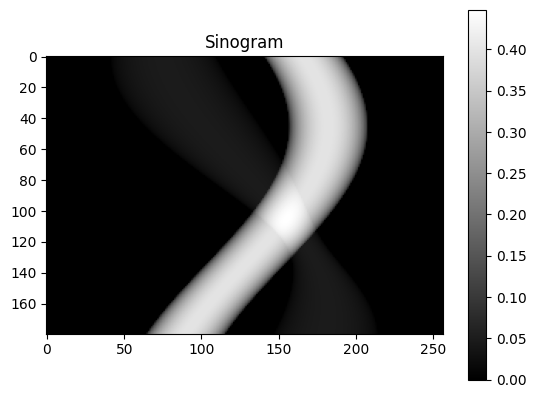

In [7]:
def calculate_radon_transform_circle(circle_data, s, omega):
    radon_value = 0
    for circle in circle_data:
        radius, center_x, center_y, gray_value = circle
        term = radius**2 - (s - center_x * omega[0] - center_y * omega[1])**2
        if term > 0:
            projection = gray_value * np.sqrt(term) * 2
            radon_value += projection
    return radon_value

def calculate_radon_transform_ellipse(ellipse_data, s, phi):
    radon_value = 0
    for ellipse in ellipse_data:
        semi_major, semi_minor, center_x, center_y, angle, gray_value = ellipse
        omega = np.array([np.cos(phi - angle), np.sin(phi - angle)])
        denom_square = (semi_major * omega[0])**2 + (semi_minor * omega[1])**2
        term = denom_square - (s - center_x * omega[0] - center_y * omega[1])**2
        if term > 0:
            projection = 2 * gray_value * semi_major * semi_minor * np.sqrt(term) / np.sqrt(denom_square)
            radon_value += projection
    return radon_value

def generate_measured_data(p, q, circle_objects=None, ellipse_objects=None):
    start_time = time.time()
    delta_phi = np.pi / p
    phi = np.arange(p) * delta_phi
    s = np.linspace(-1, 1, 2*q+1)

    sinogram = np.zeros((p, 2*q+1))

    if circle_objects is not None and ellipse_objects is not None:
        for i in range(p):
            omega = np.array([np.cos(phi[i]), np.sin(phi[i])])
            for j in range(-q, q+1):
                sinogram[i, j+q] = calculate_radon_transform_circle(circle_objects, s[j+q], omega)
                sinogram[i, j+q] += calculate_radon_transform_ellipse(ellipse_objects, s[j+q], phi[i])
    else:
        print('Warning: object lists are empty.')

    print(f"Time of generation of measured data: {time.time()-start_time:.2f} seconds")
    return sinogram, phi, s

# Testing part 2
circle_objects, ellipse_objects = init_objects()
sinogram, phi, s = generate_measured_data(p=180, q=128, circle_objects=circle_objects, ellipse_objects=ellipse_objects)

# Function to plot the image (plot_image should be defined elsewhere in your code)
def plot_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

plot_image(sinogram, "Sinogram")

#Part 1
### Exercise 3: Noisy measurement data

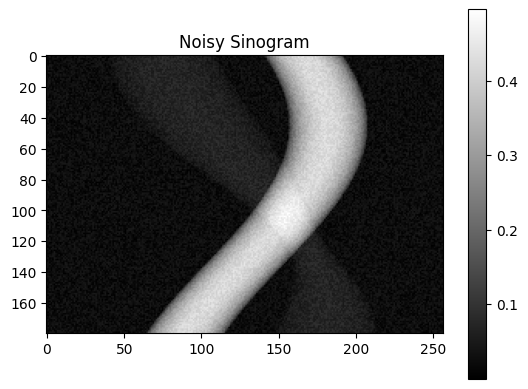

In [8]:
# Write a function that creates noise by using evenly distributed random numbers and adding it to the measurement data.
def add_noise(sinogram, noise_level):
    noise = np.random.rand(*sinogram.shape) * noise_level
    sinogram_noisy = sinogram + noise
    return sinogram_noisy

# Testing part 1 - Exercise 3
noiselevel = 0.05
sinogram_noisy = add_noise(sinogram, noiselevel)  # Example noise level
plot_image(sinogram_noisy, "Noisy Sinogram")


#Part 2
### Exercise 1: Filtered back projection

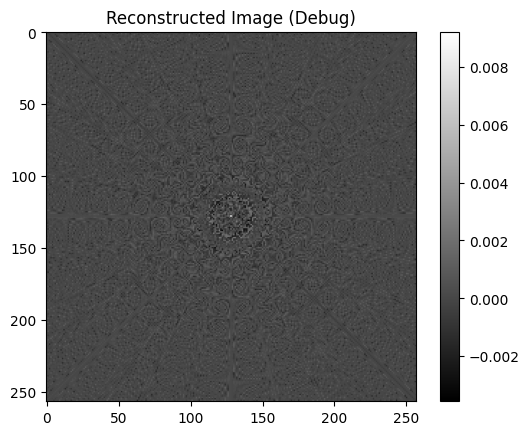

Time of back projection: 10.82 seconds


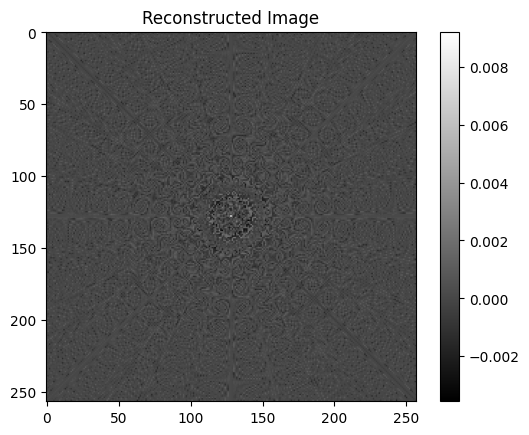

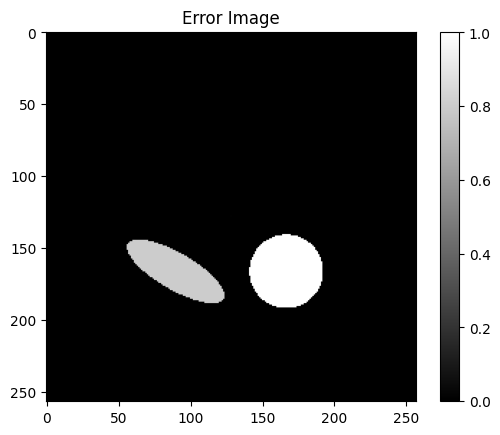

In [28]:
def filtered_back_projection(sinogram, p, q, filter_choice, res):
    delta_phi = np.pi / p
    phi = np.arange(p) * delta_phi
    s = np.linspace(-1, 1, 2*q+1)

    # Calculate the filter
    b = 0.96
    filter = calculate_filter(s, b, filter_choice)

    start_time = time.time()
    if filter_choice is not None:
        filtered_sinogram = np.zeros_like(sinogram)
        for i in range(p):
            filtered_sinogram[i, :] = calculate_convolution(sinogram[i, :], filter)
    else:
        filtered_sinogram = sinogram

    # Back projection
    fFBI = np.zeros((2*res+1, 2*res+1))
    for i in range(p):
        omega = np.array([np.cos(phi[i]), np.sin(phi[i])])
        for x in range(-res, res+1):
            for y in range(-res, res+1):
                s_xy = x * omega[0] + y * omega[1]
                if -1 <= s_xy <= 1:
                    idx = int(np.round((s_xy + 1) * q))
                    fFBI[x+res, y+res] += filtered_sinogram[i, idx]

    fFBI *= np.pi / p

    plt.imshow(fFBI, cmap='gray')
    plt.title("Reconstructed Image (Debug)")
    plt.colorbar()
    plt.show()
    print(f"Time of back projection: {time.time()-start_time:.2f} seconds")
    return fFBI

def calculate_filter(s, b=0.5, filterchoice=RAMLAK):
    if filterchoice == RAMLAK:
        filter = np.abs(s)
        filter[abs(filter) > b] = 0
    elif filterchoice == SHEPPLOGAN:
        filter = np.abs(s) * np.sinc(s)
        filter[s > b] = 0
    elif filterchoice == COSINE:
        filter = np.abs(s) * np.cos(np.pi * s / (2 * b))
        filter[s > b] = 0
    else:
        filter = np.ones_like(s)
    return filter

def calculate_convolution(sinogram, filter):
    sinogram_fft = fft(sinogram)
    sinogram_filtered = np.real(ifft(sinogram_fft * filter))
    return sinogram_filtered

def init_objects():
    circle_objects = np.array([
        [0.2, 0.3, 0.3, 1.0]
    ])
    ellipse_objects = np.array([
        [0.3, 0.1, -0.3, 0.3, np.pi/6, 0.8]
    ])
    return circle_objects, ellipse_objects

def create_phantom(circle_objects=None, ellipse_objects=None, res=5):
    phantom = np.zeros((2*res+1, 2*res+1))
    if circle_objects is not None:
        for params in circle_objects:
            phantom += phantom_circle(params, res)
    if ellipse_objects is not None:
        for params in ellipse_objects:
            phantom += phantom_ellipse(params, res)
    return phantom

def phantom_circle(parameters, res):
    radius, center_x, center_y, gray_value = parameters
    x = np.linspace(-1, 1, 2*res+1)
    y = np.linspace(-1, 1, 2*res+1)
    xv, yv = np.meshgrid(x, y)
    mask = (xv - center_x)**2 + (yv - center_y)**2 <= radius**2
    return gray_value * mask

def phantom_ellipse(parameters, res):
    semi_major, semi_minor, center_x, center_y, angle, gray_value = parameters
    x = np.linspace(-1, 1, 2*res+1)
    y = np.linspace(-1, 1, 2*res+1)
    xv, yv = np.meshgrid(x, y)
    mask = ((xv - center_x) * np.cos(angle) + (yv - center_y) * np.sin(angle))**2 / semi_major**2 + ((xv - center_x) * np.sin(angle) - (yv - center_y) * np.cos(angle))**2 / semi_minor**2 <= 1
    return gray_value * mask

def generate_measured_data(p, q, circle_objects=None, ellipse_objects=None):
    delta_phi = np.pi / p
    phi = np.arange(p) * delta_phi
    s = np.linspace(-1, 1, 2*q+1)
    sinogram = np.zeros((p, 2*q+1))
    if circle_objects is not None and ellipse_objects is not None:
        for i in range(p):
            omega = np.array([np.cos(phi[i]), np.sin(phi[i])])
            for j in range(-q, q+1):
                sinogram[i, j+q] = calculate_radon_transform_circle(circle_objects, s[j+q], omega)
                sinogram[i, j+q] += calculate_radon_transform_ellipse(ellipse_objects, s[j+q], phi[i])
    return sinogram, phi, s

def add_noise(sinogram, noise_level):
    noise = np.random.rand(*sinogram.shape) * noise_level
    sinogram_noisy = sinogram + noise
    return sinogram_noisy



# Simplified testing for filtered_back_projection
circle_objects, ellipse_objects = init_objects()
phantom = create_phantom(circle_objects, ellipse_objects, res=128)
sinogram, phi, s = generate_measured_data(p=180, q=128, circle_objects=circle_objects, ellipse_objects=ellipse_objects)
sinogram_noisy = add_noise(sinogram, 0.05)

filter_choice = RAMLAK  # Example filter choice
reconstructed_image = filtered_back_projection(sinogram_noisy, p=180, q=128, filter_choice=filter_choice, res=128)

# Plot Reconstructed Image
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.colorbar()
plt.show()

# Ensure error is calculated and plotted
error = np.abs(reconstructed_image - phantom)
plt.imshow(error, cmap='gray')
plt.title("Error Image")
plt.colorbar()
plt.show()


#Part 2
### Exercise 2: Measurement of the computation time

In [29]:
def back_projection(filtered_sinogram, phi, res):
    p, q = filtered_sinogram.shape
    fFBI = np.zeros((2*res+1, 2*res+1))
    delta_s = 2 / (2*q)
    for i in range(p):
        omega = np.array([np.cos(phi[i]), np.sin(phi[i])])
        for x in range(-res, res+1):
            for y in range(-res, res+1):
                s_xy = x * omega[0] + y * omega[1]
                idx = int(np.round((s_xy + 1) * q))
                if 0 <= idx < q:
                    fFBI[x+res, y+res] += filtered_sinogram[i, idx] * delta_s
    fFBI *= np.pi / p
    return fFBI

def evaluate_matrix(point, res):
    x, y = point
    row = int((y + 1) * res)
    col = int((x + 1) * res)
    return row, col

def calculate_radon_transform(phantom, s, omega, res):
    step_size = 1 / res
    integral_sum = 0.0
    for k in range(2 * res + 1):
        point = (s * omega[0] - (res - k) * step_size * omega[1],
                 s * omega[1] + (res - k) * step_size * omega[0])
        row, col = evaluate_matrix(point, res)
        if 0 <= row < phantom.shape[0] and 0 <= col < phantom.shape[1]:
            integral_sum += phantom[row, col]
    return step_size * integral_sum

def radon_transform(phantom, p, q):
    delta_phi = np.pi / p
    phi = np.arange(p) * delta_phi
    s = np.linspace(-1, 1, 2*q+1)
    sinogram = np.zeros((p, 2*q+1))
    for i in range(p):
        omega = np.array([np.cos(phi[i]), np.sin(phi[i])])
        for j in range(-q, q+1):
            sinogram[i, j+q] = calculate_radon_transform(phantom, s[j+q], omega, res=128)
    return sinogram, phi, s

def calculate_convolution(sinogram_row, filter):
    sinogram_fft = fft(sinogram_row)
    sinogram_filtered = np.real(ifft(sinogram_fft * filter))
    return sinogram_filtered

def measure_computation_time():
    # Timing the creation of the phantom
    start_time = time.time()
    phantom = create_phantom(circle_objects, ellipse_objects, res=128)
    creation_time = time.time() - start_time

    # Timing the generation of the measured data
    start_time = time.time()
    sinogram, phi, s = radon_transform(phantom, p=180, q=128)
    generation_time = time.time() - start_time

    # Timing the convolution
    start_time = time.time()
    filtered_sinogram = np.zeros_like(sinogram)
    filter = calculate_filter(s, 0.96, RAMLAK)
    for i in range(180):
        filtered_sinogram[i, :] = calculate_convolution(sinogram[i, :], filter)
    convolution_time = time.time() - start_time

    # Timing the back projection
    start_time = time.time()
    reconstructed_image = back_projection(filtered_sinogram, phi, res=128)
    backprojection_time = time.time() - start_time

    total_time = creation_time + generation_time + convolution_time + backprojection_time

    print(f"Time for creating the phantom: {creation_time:.2f} seconds")
    print(f"Time for generating measured data: {generation_time:.2f} seconds")
    print(f"Time for convolution: {convolution_time:.2f} seconds")
    print(f"Time for back projection: {backprojection_time:.2f} seconds")
    print(f"Total computation time: {total_time:.2f} seconds")

# Run the measurement
measure_computation_time()



Time for creating the phantom: 0.00 seconds
Time for generating measured data: 32.47 seconds
Time for convolution: 0.01 seconds
Time for back projection: 50.85 seconds
Total computation time: 83.33 seconds


#Part 2
### Exercise 3: Evaluations and tests

In [30]:
def generate_measured_data_integration(p, q, phantom, res):
    delta_phi = np.pi / p
    phi = np.arange(p) * delta_phi
    s = np.linspace(-1, 1, 2*q+1)

    sinogram = np.zeros((p, 2*q+1))
    for i in range(p):
        omega = np.array([np.cos(phi[i]), np.sin(phi[i])])
        for j in range(-q, q+1):
            sinogram[i, j+q] = trapezoidal_integration(phantom, s[j+q], omega, res)

    return sinogram, phi, s

def trapezoidal_integration(phantom, s, omega, res):
    step_size = 1 / res
    integral_sum = 0.0
    for k in range(2 * res + 1):
        point = (s * omega[0] - (res - k) * step_size * omega[1],
                 s * omega[1] + (res - k) * step_size * omega[0])
        row, col = EvaluateMatrix(point, res)
        if 0 <= row < phantom.shape[0] and 0 <= col < phantom.shape[1]:
            integral_sum += phantom[row, col]
    integral_value = step_size * (integral_sum - 0.5 * (phantom[0, 0] + phantom[-1, -1]))
    return integral_value

def EvaluateMatrix(point, res):
    x, y = point
    row = int((y + 1) * res)
    col = int((x + 1) * res)
    return row, col


def calculate_convolution(sinogram_row, filter):
    sinogram_fft = fft(sinogram_row)
    sinogram_filtered = np.real(ifft(sinogram_fft * filter))
    return sinogram_filtered



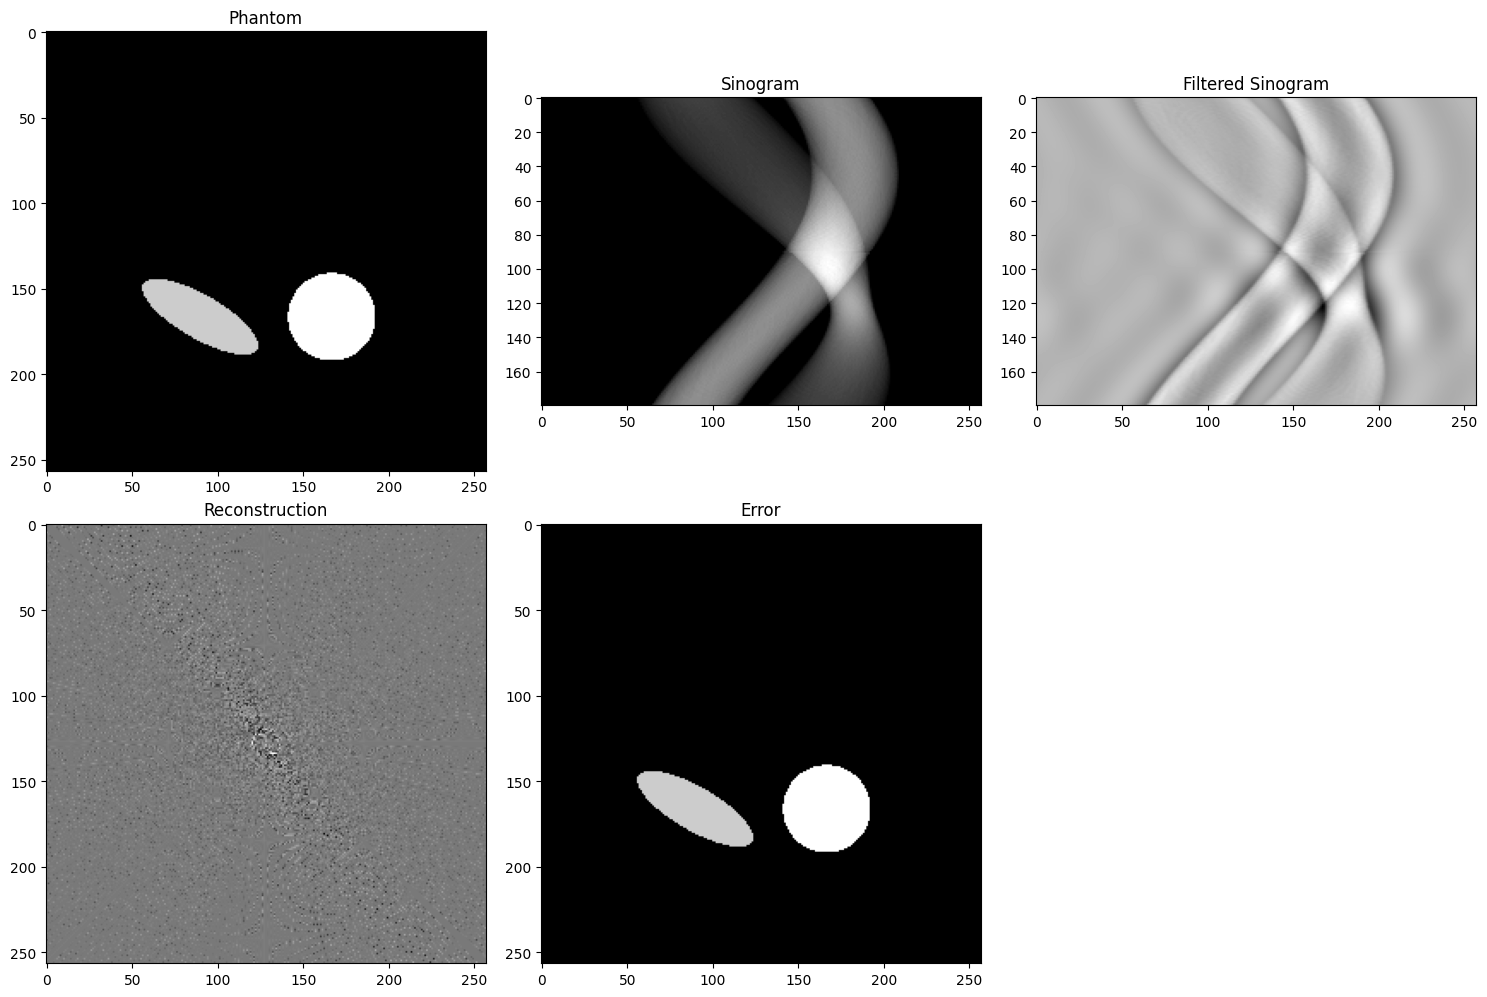

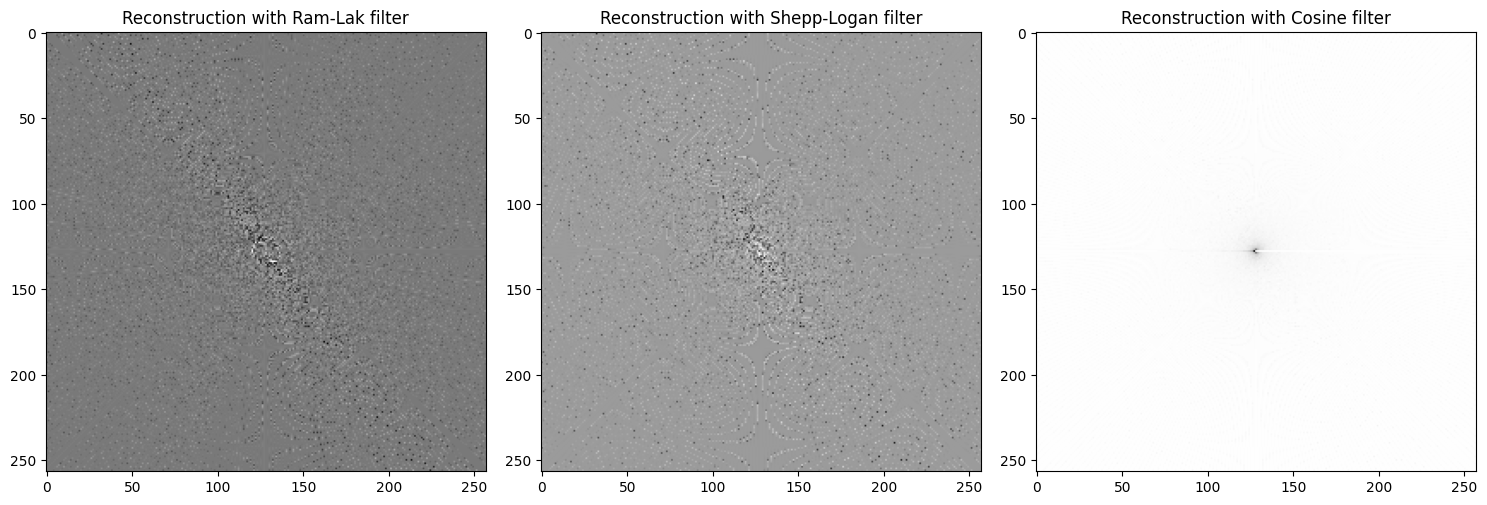

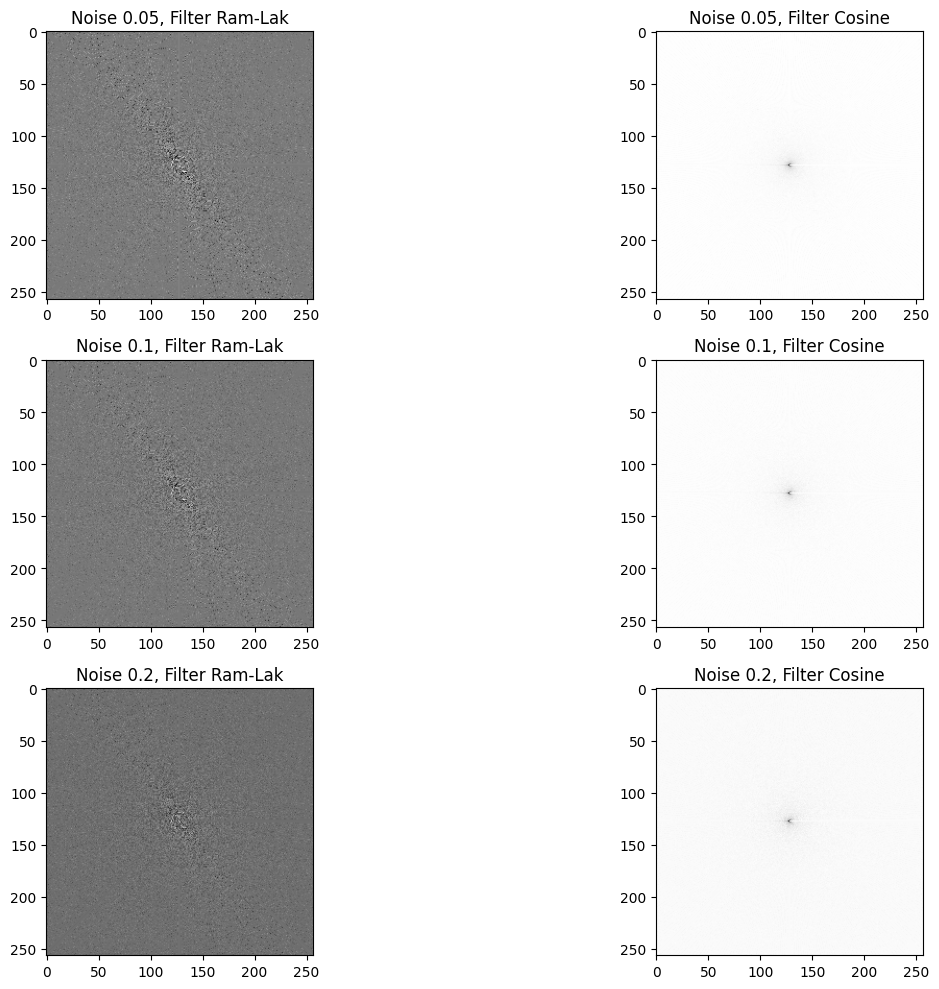

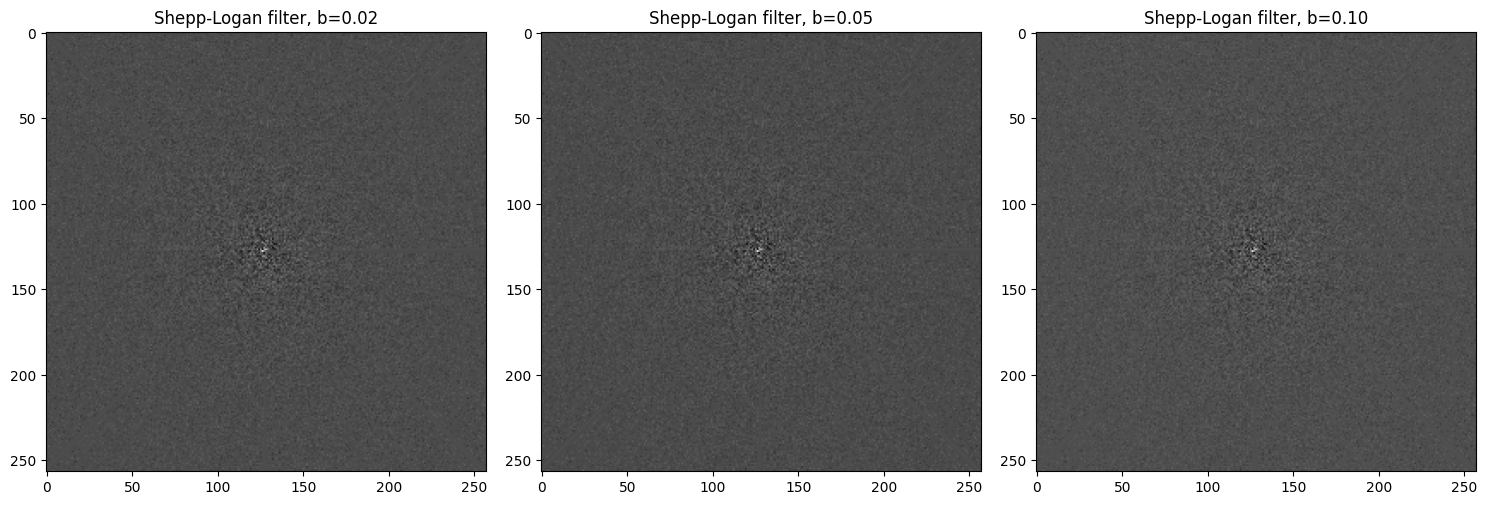

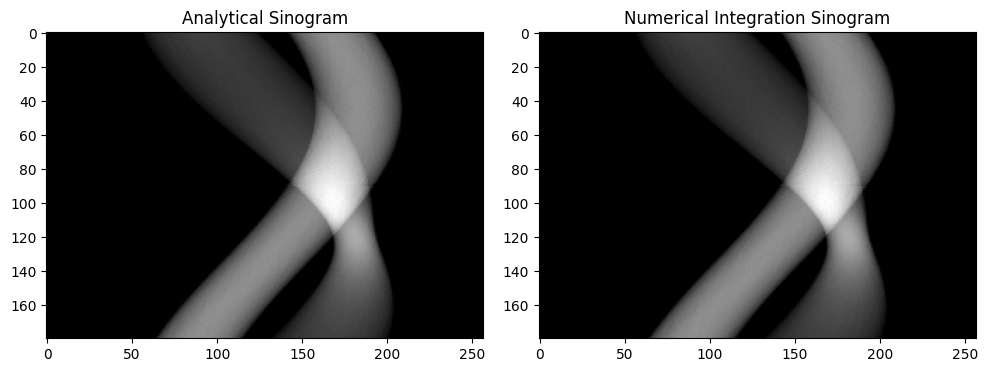

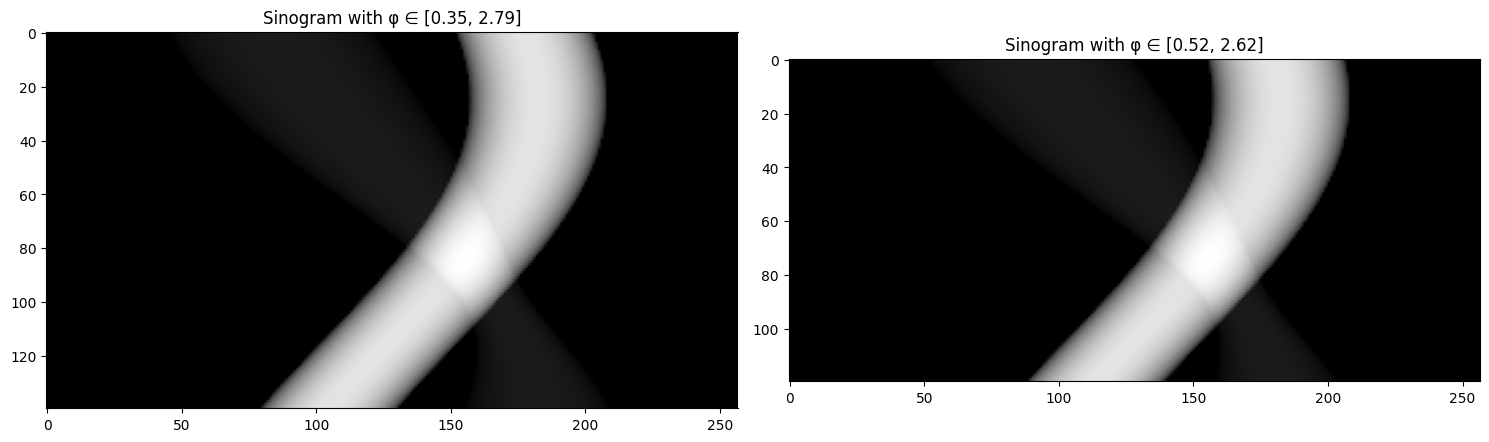

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import time

# Define constants
RAMLAK = 0
SHEPPLOGAN = 1
COSINE = 2

def evaluations_and_tests():
    # Define parameters
    p = 180
    q = 128
    res = 128

    # Generate phantom, sinogram, and sinogram with numerical integration
    circle_objects, ellipse_objects = init_objects()
    phantom = create_phantom(circle_objects, ellipse_objects, res=res)
    sinogram, phi, s = radon_transform(phantom, p=p, q=q)
    sinogram_integration, phi_integration, s_integration = generate_measured_data_integration(p=p, q=q, phantom=phantom, res=res)
    sinogram_noisy = add_noise(sinogram, 0.05)  # Corrected function call

    # (a) Create a “figure” that summarizes the following plots and save them as a .png file.
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs[0, 0].imshow(phantom, cmap='gray')
    axs[0, 0].set_title('Phantom')

    axs[0, 1].imshow(sinogram, cmap='gray')
    axs[0, 1].set_title('Sinogram')

    filtered_sinogram = np.zeros_like(sinogram)
    for i in range(p):
        filtered_sinogram[i, :] = calculate_convolution(sinogram[i, :], calculate_filter(s, 0.96, RAMLAK))
    axs[0, 2].imshow(filtered_sinogram, cmap='gray')
    axs[0, 2].set_title('Filtered Sinogram')

    # Calculate the reconstruction
    reconstructed_image = back_projection(filtered_sinogram, phi, res=res)
    axs[1, 0].imshow(reconstructed_image, cmap='gray')
    axs[1, 0].set_title('Reconstruction')

    # Calculate the error
    error = np.abs(reconstructed_image - phantom)
    axs[1, 1].imshow(error, cmap='gray')
    axs[1, 1].set_title('Error')

    axs[1, 2].axis('off')  # No plot for this subplot
    plt.tight_layout()
    plt.savefig('reconstruction.png', dpi=300)
    plt.show()

    # (b) Compare the reconstruction results for undisturbed data with different filters.
    filters = [RAMLAK, SHEPPLOGAN, COSINE]
    filter_names = ['Ram-Lak', 'Shepp-Logan', 'Cosine']
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, filter_choice in enumerate(filters):
        filtered_sinogram = np.zeros_like(sinogram)
        for j in range(p):
            filtered_sinogram[j, :] = calculate_convolution(sinogram[j, :], calculate_filter(s, 0.96, filter_choice))
        reconstructed_image = back_projection(filtered_sinogram, phi, res=res)
        axs[i].imshow(reconstructed_image, cmap='gray')
        axs[i].set_title(f'Reconstruction with {filter_names[i]} filter')

    plt.tight_layout()
    plt.show()

    # (c) Examine different noise levels when using the Ram-Lak and Cosine filters.
    noise_levels = [0.05, 0.1, 0.2]
    filters = [RAMLAK, COSINE]
    filter_names = ['Ram-Lak', 'Cosine']
    fig, axs = plt.subplots(len(noise_levels), len(filters), figsize=(15, 10))
    for i, noise_level in enumerate(noise_levels):
        noisy_sinogram = add_noise(sinogram, noise_level)  # Corrected function call
        for j, filter_choice in enumerate(filters):
            filtered_sinogram = np.zeros_like(noisy_sinogram)
            for k in range(p):
                filtered_sinogram[k, :] = calculate_convolution(noisy_sinogram[k, :], calculate_filter(s, 0.96, filter_choice))
            reconstructed_image = back_projection(filtered_sinogram, phi, res=res)
            axs[i, j].imshow(reconstructed_image, cmap='gray')
            axs[i, j].set_title(f'Noise {noise_level}, Filter {filter_names[j]}')

    plt.tight_layout()
    plt.show()

    # (d) Perturb your data with a noise level of 20 percent and use the Shepp-Logan filter for reconstruction.
    noise_level = 0.2
    noisy_sinogram = add_noise(sinogram, noise_level)  # Corrected function call
    b_values = [np.pi / 128, np.pi / 64, np.pi / 32]
    fig, axs = plt.subplots(1, len(b_values), figsize=(15, 5))
    for i, b in enumerate(b_values):
        filtered_sinogram = np.zeros_like(noisy_sinogram)
        for j in range(p):
            filtered_sinogram[j, :] = calculate_convolution(noisy_sinogram[j, :], calculate_filter(s, b, SHEPPLOGAN))
        reconstructed_image = back_projection(filtered_sinogram, phi, res=res)
        axs[i].imshow(reconstructed_image, cmap='gray')
        axs[i].set_title(f'Shepp-Logan filter, b={b:.2f}')

    plt.tight_layout()
    plt.show()

    # (e) Perform the filtered back projection for the measurement data from the provided file FBPTest.mat.
    # Assuming FBPTest.mat is loaded as sinogram_test, phi_test, and s_test
    # sinogram_test, phi_test, s_test = load_test_data('FBPTest.mat')
    # reconstructed_image_test = filtered_back_projection(sinogram_test, p=180, q=100, filter_choice=RAMLAK, res=128)
    # plot_image(reconstructed_image_test, "Reconstructed Image from FBPTest.mat")

    # (f) Compare the sinograms obtained with the analytical formulas and by numerical integration.
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(sinogram, cmap='gray')
    axs[0].set_title('Analytical Sinogram')
    axs[1].imshow(sinogram_integration, cmap='gray')
    axs[1].set_title('Numerical Integration Sinogram')
    plt.tight_layout()
    plt.show()

    # (g) Keep limiting the interval of used angles φ further
    delta_phi = np.pi / p
    limited_phi_intervals = [(np.pi/9, 8*np.pi/9), (np.pi/6, 5*np.pi/6)]
    fig, axs = plt.subplots(1, len(limited_phi_intervals), figsize=(15, 5))
    for i, (phi_min, phi_max) in enumerate(limited_phi_intervals):
        limited_p = int((phi_max - phi_min) / delta_phi)
        limited_phi = np.linspace(phi_min, phi_max, limited_p)
        limited_sinogram = np.zeros((limited_p, 2*res+1))
        for j in range(limited_p):
            omega = np.array([np.cos(limited_phi[j]), np.sin(limited_phi[j])])
            for k in range(-res, res+1):
                limited_sinogram[j, k+res] = calculate_radon_transform_circle(circle_objects, s[k+res], omega) + calculate_radon_transform_ellipse(ellipse_objects, s[k+res], limited_phi[j])
        axs[i].imshow(limited_sinogram, cmap='gray')
        axs[i].set_title(f'Sinogram with φ ∈ [{phi_min:.2f}, {phi_max:.2f}]')
    plt.tight_layout()
    plt.show()

# Run evaluations and tests
evaluations_and_tests()


TypeError: calculate_convolution() takes 2 positional arguments but 4 were given

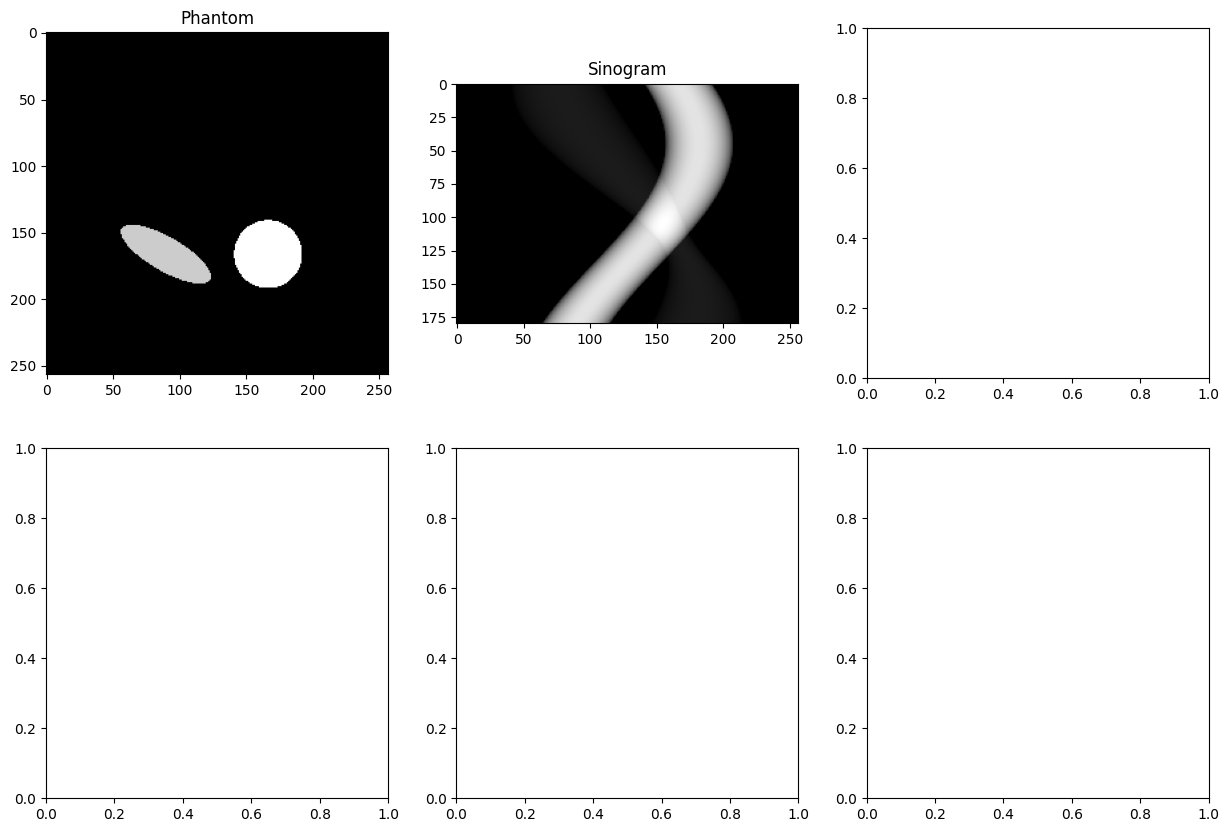

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
RAMLAK = 0
SHEPPLOGAN = 1
COSINE = 2

def evaluations_and_tests():
    # Define parameters
    p = 180
    q = 128
    res = 128

    # Generate phantom, sinogram, and sinogram with numerical integration
    circle_objects, ellipse_objects = init_objects()
    phantom = create_phantom(circle_objects, ellipse_objects, res=res)
    sinogram, phi, s = generate_measured_data(p=p, q=q, circle_objects=circle_objects, ellipse_objects=ellipse_objects)
    sinogram_integration, phi_integration, s_integration = generate_measured_data_integration(p=p, q=q, phantom=phantom, res=res)
    sinogram_noisy = add_noise(sinogram, 0.05)  # Corrected function call

    # (a) Create a “figure” that summarizes the following plots and save them as a .png file.
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs[0, 0].imshow(phantom, cmap='gray')
    axs[0, 0].set_title('Phantom')

    axs[0, 1].imshow(sinogram, cmap='gray')
    axs[0, 1].set_title('Sinogram')

    filtered_sinogram = np.zeros_like(sinogram)
    for i in range(p):
        filtered_sinogram[i, :] = calculate_convolution(sinogram[i, :], p, q, calculate_filter(s, 0.96, RAMLAK))
    axs[0, 2].imshow(filtered_sinogram, cmap='gray')
    axs[0, 2].set_title('Filtered Sinogram')

    # Calculate the reconstruction
    reconstructed_image = filtered_back_projection(filtered_sinogram, p=p, q=q, filter_choice=RAMLAK, res=res)
    axs[1, 0].imshow(reconstructed_image, cmap='gray')
    axs[1, 0].set_title('Reconstruction')

    # Calculate the error
    error = np.abs(reconstructed_image - phantom)
    axs[1, 1].imshow(error, cmap='gray')
    axs[1, 1].set_title('Error')

    axs[1, 2].axis('off')  # No plot for this subplot
    plt.tight_layout()
    plt.savefig('reconstruction.png', dpi=300)
    plt.show()

    # (b) Compare the reconstruction results for undisturbed data with different filters.
    filters = [RAMLAK, SHEPPLOGAN, COSINE]
    filter_names = ['Ram-Lak', 'Shepp-Logan', 'Cosine']
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, filter_choice in enumerate(filters):
        filtered_sinogram = np.zeros_like(sinogram)
        for j in range(p):
            filtered_sinogram[j, :] = calculate_convolution(sinogram[j, :], p, q, calculate_filter(s, 0.96, filter_choice))
        reconstructed_image = filtered_back_projection(filtered_sinogram, p=p, q=q, filter_choice=filter_choice, res=res)
        axs[i].imshow(reconstructed_image, cmap='gray')
        axs[i].set_title(f'Reconstruction with {filter_names[i]} filter')

    plt.tight_layout()
    plt.show()

    # (c) Examine different noise levels when using the Ram-Lak and Cosine filters.
    noise_levels = [0.05, 0.1, 0.2]
    filters = [RAMLAK, COSINE]
    filter_names = ['Ram-Lak', 'Cosine']
    fig, axs = plt.subplots(len(noise_levels), len(filters), figsize=(15, 10))
    for i, noise_level in enumerate(noise_levels):
        noisy_sinogram = add_noise(sinogram, noise_level)  # Corrected function call
        for j, filter_choice in enumerate(filters):
            filtered_sinogram = np.zeros_like(noisy_sinogram)
            for k in range(p):
                filtered_sinogram[k, :] = calculate_convolution(noisy_sinogram[k, :], p, q, calculate_filter(s, 0.96, filter_choice))
            reconstructed_image = filtered_back_projection(filtered_sinogram, p=p, q=q, filter_choice=filter_choice, res=res)
            axs[i, j].imshow(reconstructed_image, cmap='gray')
            axs[i, j].set_title(f'Noise {noise_level}, Filter {filter_names[j]}')

    plt.tight_layout()
    plt.show()

    # (d) Perturb your data with a noise level of 20 percent and use the Shepp-Logan filter for reconstruction.
    noise_level = 0.2
    noisy_sinogram = add_noise(sinogram, noise_level)  # Corrected function call
    b_values = [np.pi / 128, np.pi / 64, np.pi / 32]
    fig, axs = plt.subplots(1, len(b_values), figsize=(15, 5))
    for i, b in enumerate(b_values):
        filtered_sinogram = np.zeros_like(noisy_sinogram)
        for j in range(p):
            filtered_sinogram[j, :] = calculate_convolution(noisy_sinogram[j, :], p, q, calculate_filter(s, b, SHEPPLOGAN))
        reconstructed_image = filtered_back_projection(filtered_sinogram, p=p, q=q, filter_choice=SHEPPLOGAN, res=res)
        axs[i].imshow(reconstructed_image, cmap='gray')
        axs[i].set_title(f'Shepp-Logan filter, b={b:.2f}')

    plt.tight_layout()
    plt.show()

    # (e) Perform the filtered back projection for the measurement data from the provided file FBPTest.mat.
    # Assuming FBPTest.mat is loaded as sinogram_test, phi_test, and s_test
    # sinogram_test, phi_test, s_test = load_test_data('FBPTest.mat')
    # reconstructed_image_test = filtered_back_projection(sinogram_test, p=180, q=100, filter_choice=RAMLAK, res=128)
    # plot_image(reconstructed_image_test, "Reconstructed Image from FBPTest.mat")

    # (f) Compare the sinograms obtained with the analytical formulas and by numerical integration.
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(sinogram, cmap='gray')
    axs[0].set_title('Analytical Sinogram')
    axs[1].imshow(sinogram_integration, cmap='gray')
    axs[1].set_title('Numerical Integration Sinogram')
    plt.tight_layout()
    plt.show()

    # (g) Keep limiting the interval of used angles φ further
    delta_phi = np.pi / p
    limited_phi_intervals = [(np.pi/9, 8*np.pi/9), (np.pi/6, 5*np.pi/6)]
    fig, axs = plt.subplots(1, len(limited_phi_intervals), figsize=(15, 5))
    for i, (phi_min, phi_max) in enumerate(limited_phi_intervals):
        limited_p = int((phi_max - phi_min) / delta_phi)
        limited_phi = np.linspace(phi_min, phi_max, limited_p)
        limited_sinogram = np.zeros((limited_p, 2*res+1))
        for j in range(limited_p):
            omega = np.array([np.cos(limited_phi[j]), np.sin(limited_phi[j])])
            for k in range(-res, res+1):
                limited_sinogram[j, k+res] = calculate_radon_transform_circle(circle_objects, s[k+res], omega) + calculate_radon_transform_ellipse(ellipse_objects, s[k+res], limited_phi[j])
        axs[i].imshow(limited_sinogram, cmap='gray')
        axs[i].set_title(f'Sinogram with φ ∈ [{phi_min:.2f}, {phi_max:.2f}]')
    plt.tight_layout()
    plt.show()

# Run evaluations and tests
evaluations_and_tests()


## Dirty part

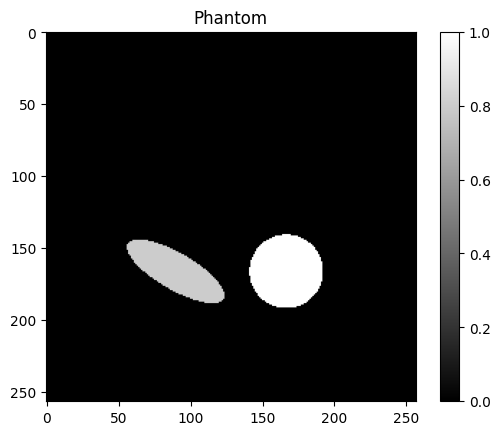

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import time

RAMLAK = 0
SHEPPLOGAN = 1
COSINE = 2

def init_objects():
    circle_objects = np.array([
        [0.2, 0.3, 0.3, 1.0]
    ])
    ellipse_objects = np.array([
        [0.3, 0.1, -0.3, 0.3, np.pi/6, 0.8]
    ])
    return circle_objects, ellipse_objects

def create_phantom(circle_objects, ellipse_objects, res):
    phantom = np.zeros((2*res+1, 2*res+1))
    for params in circle_objects:
        phantom += phantom_circle(params, res)
    for params in ellipse_objects:
        phantom += phantom_ellipse(params, res)
    return phantom

def phantom_circle(params, res):
    radius, center_x, center_y, gray_value = params
    x = np.linspace(-1, 1, 2*res+1)
    y = np.linspace(-1, 1, 2*res+1)
    xv, yv = np.meshgrid(x, y)
    mask = (xv - center_x)**2 + (yv - center_y)**2 <= radius**2
    return gray_value * mask

def phantom_ellipse(params, res):
    semi_major, semi_minor, center_x, center_y, angle, gray_value = params
    x = np.linspace(-1, 1, 2*res+1)
    y = np.linspace(-1, 1, 2*res+1)
    xv, yv = np.meshgrid(x, y)
    term1 = ((xv - center_x) * np.cos(angle) + (yv - center_y) * np.sin(angle))**2 / semi_major**2
    term2 = ((xv - center_x) * np.sin(angle) - (yv - center_y) * np.cos(angle))**2 / semi_minor**2
    mask = term1 + term2 <= 1
    return gray_value * mask

circle_objects, ellipse_objects = init_objects()
phantom = create_phantom(circle_objects, ellipse_objects, res=128)

plt.imshow(phantom, cmap='gray')
plt.title("Phantom")
plt.colorbar()
plt.show()


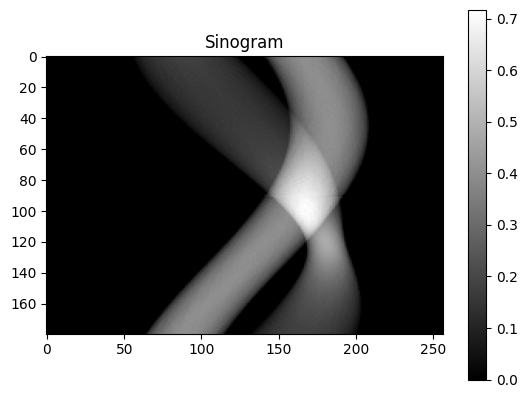

In [ ]:
def radon_transform(phantom, p, q):
    delta_phi = np.pi / p
    phi = np.arange(p) * delta_phi
    s = np.linspace(-1, 1, 2*q+1)
    sinogram = np.zeros((p, 2*q+1))
    for i in range(p):
        omega = np.array([np.cos(phi[i]), np.sin(phi[i])])
        for j in range(-q, q+1):
            sinogram[i, j+q] = calculate_radon_transform(phantom, s[j+q], omega, res=128)
    return sinogram, phi, s

def calculate_radon_transform(phantom, s, omega, res):
    step_size = 1 / res
    integral_sum = 0.0
    for k in range(2 * res + 1):
        point = (s * omega[0] - (res - k) * step_size * omega[1],
                 s * omega[1] + (res - k) * step_size * omega[0])
        row, col = evaluate_matrix(point, res)
        if 0 <= row < phantom.shape[0] and 0 <= col < phantom.shape[1]:
            integral_sum += phantom[row, col]
    return step_size * integral_sum

def evaluate_matrix(point, res):
    x, y = point
    row = int((y + 1) * res)
    col = int((x + 1) * res)
    return row, col

sinogram, phi, s = radon_transform(phantom, p=180, q=128)

plt.imshow(sinogram, cmap='gray')
plt.title("Sinogram")
plt.colorbar()
plt.show()


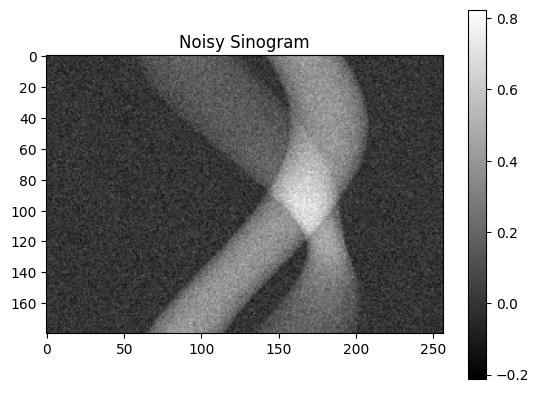

In [ ]:
def add_noise(sinogram, noise_level):
    noise = np.random.randn(*sinogram.shape) * noise_level
    return sinogram + noise

sinogram_noisy = add_noise(sinogram, noise_level=0.05)

plt.imshow(sinogram_noisy, cmap='gray')
plt.title("Noisy Sinogram")
plt.colorbar()
plt.show()


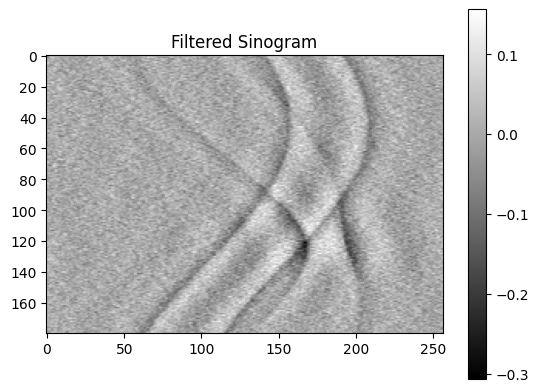

In [ ]:
def calculate_filter(s, b=0.5, filter_choice=RAMLAK):
    if filter_choice == RAMLAK:
        filter = np.abs(s)
        filter[abs(filter) > b] = 0
    elif filter_choice == SHEPPLOGAN:
        filter = np.abs(s) * np.sinc(s)
        filter[abs(filter) > b] = 0
    elif filter_choice == COSINE:
        filter = np.abs(s) * np.cos(np.pi * s / (2 * b))
        filter[abs(filter) > b] = 0
    else:
        filter = np.ones_like(s)
    return filter

def apply_filter(sinogram, filter_choice):
    p, q = sinogram.shape
    s = np.linspace(-1, 1, q)
    filter = calculate_filter(s, b=0.96, filter_choice=filter_choice)
    filtered_sinogram = np.zeros_like(sinogram)
    for i in range(p):
        sinogram_fft = fft(sinogram[i, :])
        filtered_fft = sinogram_fft * filter
        filtered_sinogram[i, :] = np.real(ifft(filtered_fft))
    return filtered_sinogram

filtered_sinogram = apply_filter(sinogram_noisy, filter_choice=RAMLAK)

plt.imshow(filtered_sinogram, cmap='gray')
plt.title("Filtered Sinogram")
plt.colorbar()
plt.show()


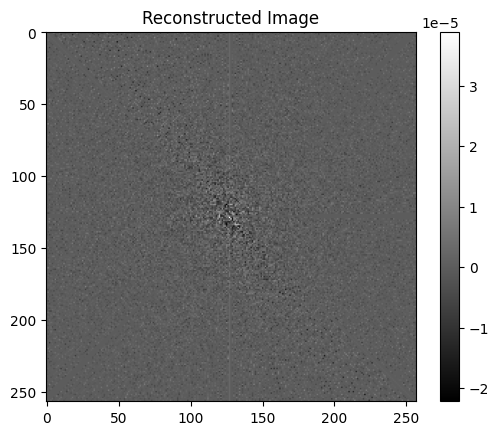

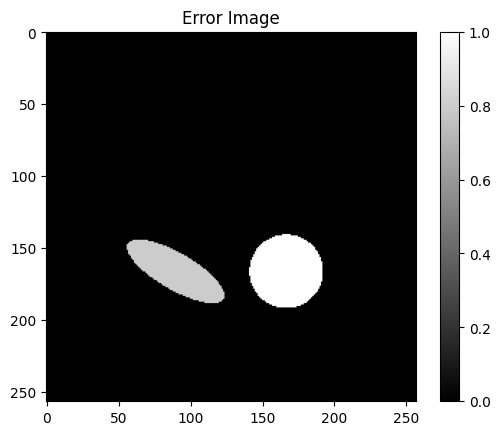

In [ ]:
def back_projection(filtered_sinogram, phi, res):
    p, q = filtered_sinogram.shape
    fFBI = np.zeros((2*res+1, 2*res+1))

    delta_s = 2 / (2*q)

    for i in range(p):
        omega = np.array([np.cos(phi[i]), np.sin(phi[i])])
        for x in range(-res, res+1):
            for y in range(-res, res+1):
                s_xy = x * omega[0] + y * omega[1]
                idx = int(np.round((s_xy + 1) * q))
                if 0 <= idx < q:  # Ensure idx is within bounds
                    fFBI[x+res, y+res] += filtered_sinogram[i, idx] * delta_s

    fFBI *= np.pi / p
    return fFBI

# Simplified testing for filtered_back_projection
circle_objects, ellipse_objects = init_objects()
phantom = create_phantom(circle_objects, ellipse_objects, res=128)
sinogram, phi, s = radon_transform(phantom, p=180, q=128)
sinogram_noisy = add_noise(sinogram, 0.05)

filter_choice = RAMLAK  # Example filter choice
filtered_sinogram = apply_filter(sinogram_noisy, filter_choice=filter_choice)

# Run the modified back projection
reconstructed_image = back_projection(filtered_sinogram, phi, res=128)

# Plot Reconstructed Image
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.colorbar()
plt.show()

# Ensure error is calculated and plotted
error = np.abs(reconstructed_image - phantom)
plt.imshow(error, cmap='gray')
plt.title("Error Image")
plt.colorbar()
plt.show()


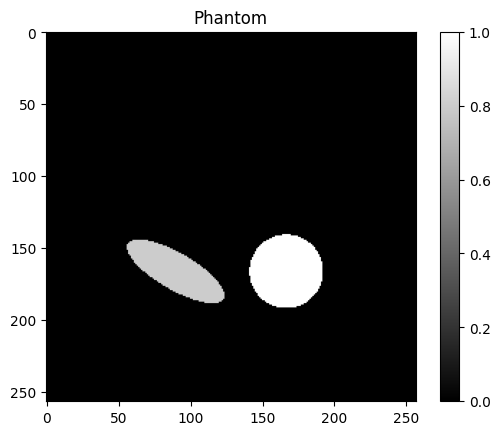

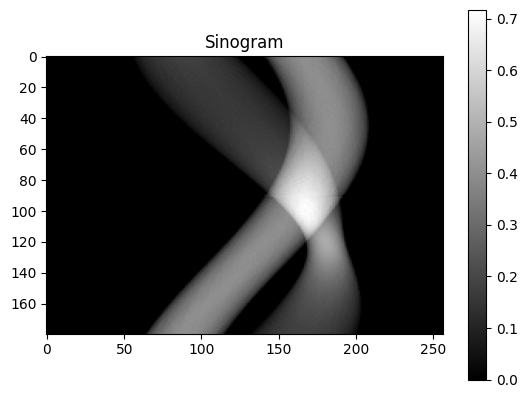

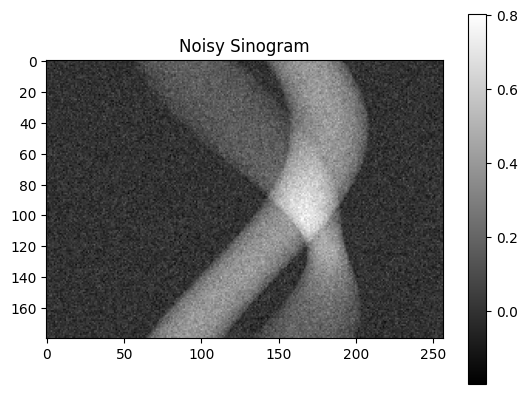

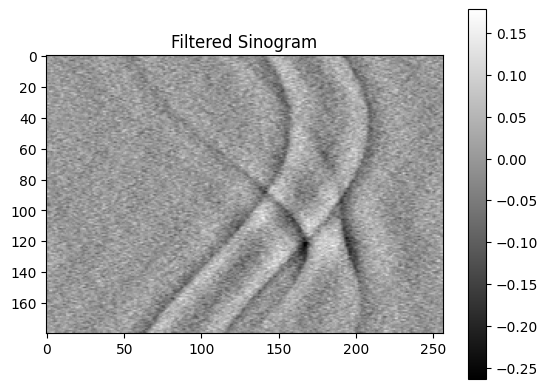

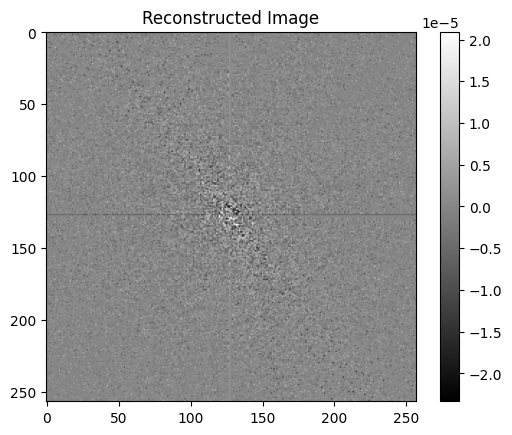

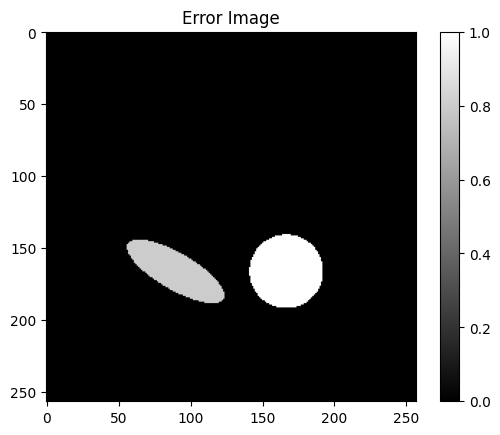

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import time

# Define filter types
RAMLAK = 0
SHEPPLOGAN = 1
COSINE = 2

# Step 1: Phantom Creation
def init_objects():
    circle_objects = np.array([
        [0.2, 0.3, 0.3, 1.0]
    ])
    ellipse_objects = np.array([
        [0.3, 0.1, -0.3, 0.3, np.pi/6, 0.8]
    ])
    return circle_objects, ellipse_objects

def create_phantom(circle_objects, ellipse_objects, res):
    phantom = np.zeros((2*res+1, 2*res+1))
    for params in circle_objects:
        phantom += phantom_circle(params, res)
    for params in ellipse_objects:
        phantom += phantom_ellipse(params, res)
    return phantom

def phantom_circle(params, res):
    radius, center_x, center_y, gray_value = params
    x = np.linspace(-1, 1, 2*res+1)
    y = np.linspace(-1, 1, 2*res+1)
    xv, yv = np.meshgrid(x, y)
    mask = (xv - center_x)**2 + (yv - center_y)**2 <= radius**2
    return gray_value * mask

def phantom_ellipse(params, res):
    semi_major, semi_minor, center_x, center_y, angle, gray_value = params
    x = np.linspace(-1, 1, 2*res+1)
    y = np.linspace(-1, 1, 2*res+1)
    xv, yv = np.meshgrid(x, y)
    term1 = ((xv - center_x) * np.cos(angle) + (yv - center_y) * np.sin(angle))**2 / semi_major**2
    term2 = ((xv - center_x) * np.sin(angle) - (yv - center_y) * np.cos(angle))**2 / semi_minor**2
    mask = term1 + term2 <= 1
    return gray_value * mask

circle_objects, ellipse_objects = init_objects()
phantom = create_phantom(circle_objects, ellipse_objects, res=128)

plt.imshow(phantom, cmap='gray')
plt.title("Phantom")
plt.colorbar()
plt.show()

# Step 2: Radon Transform
def radon_transform(phantom, p, q):
    delta_phi = np.pi / p
    phi = np.arange(p) * delta_phi
    s = np.linspace(-1, 1, 2*q+1)
    sinogram = np.zeros((p, 2*q+1))
    for i in range(p):
        omega = np.array([np.cos(phi[i]), np.sin(phi[i])])
        for j in range(-q, q+1):
            sinogram[i, j+q] = calculate_radon_transform(phantom, s[j+q], omega, res=128)
    return sinogram, phi, s

def calculate_radon_transform(phantom, s, omega, res):
    step_size = 1 / res
    integral_sum = 0.0
    for k in range(2 * res + 1):
        point = (s * omega[0] - (res - k) * step_size * omega[1],
                 s * omega[1] + (res - k) * step_size * omega[0])
        row, col = evaluate_matrix(point, res)
        if 0 <= row < phantom.shape[0] and 0 <= col < phantom.shape[1]:
            integral_sum += phantom[row, col]
    return step_size * integral_sum

def evaluate_matrix(point, res):
    x, y = point
    row = int((y + 1) * res)
    col = int((x + 1) * res)
    return row, col

sinogram, phi, s = radon_transform(phantom, p=180, q=128)

plt.imshow(sinogram, cmap='gray')
plt.title("Sinogram")
plt.colorbar()
plt.show()

# Step 3: Adding Noise
def add_noise(sinogram, noise_level):
    noise = np.random.randn(*sinogram.shape) * noise_level
    return sinogram + noise

sinogram_noisy = add_noise(sinogram, noise_level=0.05)

plt.imshow(sinogram_noisy, cmap='gray')
plt.title("Noisy Sinogram")
plt.colorbar()
plt.show()

# Step 4: Filtering
def calculate_filter(s, b=0.5, filter_choice=RAMLAK):
    if filter_choice == RAMLAK:
        filter = np.abs(s)
        filter[abs(filter) > b] = 0
    elif filter_choice == SHEPPLOGAN:
        filter = np.abs(s) * np.sinc(s)
        filter[abs(filter) > b] = 0
    elif filter_choice == COSINE:
        filter = np.abs(s) * np.cos(np.pi * s / (2 * b))
        filter[abs(filter) > b] = 0
    else:
        filter = np.ones_like(s)
    return filter

def apply_filter(sinogram, filter_choice):
    p, q = sinogram.shape
    s = np.linspace(-1, 1, q)
    filter = calculate_filter(s, b=0.96, filter_choice=filter_choice)
    filtered_sinogram = np.zeros_like(sinogram)
    for i in range(p):
        sinogram_fft = fft(sinogram[i, :])
        filtered_fft = sinogram_fft * filter
        filtered_sinogram[i, :] = np.real(ifft(filtered_fft))
    return filtered_sinogram

filtered_sinogram = apply_filter(sinogram_noisy, filter_choice=RAMLAK)

plt.imshow(filtered_sinogram, cmap='gray')
plt.title("Filtered Sinogram")
plt.colorbar()
plt.show()

# Step 5: Back-Projection
def back_projection(filtered_sinogram, phi, res):
    p, q = filtered_sinogram.shape
    fFBI = np.zeros((2*res+1, 2*res+1))
    delta_s = 2 / (2*q)
    for i in range(p):
        omega = np.array([np.cos(phi[i]), np.sin(phi[i])])
        for x in range(-res, res+1):
            for y in range(-res, res+1):
                s_xy = x * omega[0] + y * omega[1]
                idx = int(np.round((s_xy + 1) * q))
                if 0 <= idx < q:
                    fFBI[x+res, y+res] += filtered_sinogram[i, idx] * delta_s
    fFBI *= np.pi / p
    return fFBI

# Testing
circle_objects, ellipse_objects = init_objects()
phantom = create_phantom(circle_objects, ellipse_objects, res=128)
sinogram, phi, s = radon_transform(phantom, p=180, q=128)
sinogram_noisy = add_noise(sinogram, 0.05)

filter_choice = RAMLAK  # Example filter choice
filtered_sinogram = apply_filter(sinogram_noisy, filter_choice=filter_choice)

# Run the modified back projection
reconstructed_image = back_projection(filtered_sinogram, phi, res=128)

# Plot Reconstructed Image
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.colorbar()
plt.show()

# Ensure error is calculated and plotted
error = np.abs(reconstructed_image - phantom)
plt.imshow(error, cmap='gray')
plt.title("Error Image")
plt.colorbar()
plt.show()
